In [ ]:
!pip install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio==0.8.2 -f
!pip install datasets
!pip install transformers
!pip install rouge
!pip install accelerate -U


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-f option requires 1 argument


In [ ]:
import torch

In [ ]:
from transformers import pipeline

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

loading dataset

In [ ]:
# Load the "ms2_sparse_max" dataset
ms2_dataset = load_dataset("medical_meadow_cord19", split="test")

In [ ]:
# @title Default title text
ms2_dataset.to_pandas()

,review_id,pmid,title,abstract,target,background
0,24894943,"[19632716, 20573926, 23724913, 21903745]",[Radiotherapy plus chemotherapy with or withou...,[BACKGROUND Results from phase II studies in p...,,INTRODUCTION / BACKGROUND An individual patien...
1,25367179,"[19784660, 2390908, 16703429, 15496622, 179367...",[Effects of preoperative chemoradiotherapy on ...,[Purpose Deterioration of anorectal function a...,,Background Low rectal cancer is conventionally...
2,27841442,"[9550512, 12920254, 15929503, 19321521, 151942...",[Effect of a therapeutic intervention for the ...,[BACKGROUND AND PURPOSE Arm function recovery ...,,BACKGROUND Repetitive task training ( RTT ) in...
3,28764600,"[3527357, 4679833, 23842842, 4226213, 19250152...",[Internet-based psychoeducation for bipolar di...,[Background In a recent exploratory r and omis...,,There is a gap in knowledge of women 's percep...
4,26262909,"[15592289, 11110329, 10907623, 18768245, 13750...",[Sleep in late pregnancy predicts length of la...,[OBJECTIVE The purpose of this study was to te...,,BACKGROUND Leg cramps are a common problem in ...
...,...,...,...,...,...,...
1662,23881744,"[16263773, 9831573, 109596, 16615955, 19573436...",[Effect of intravenous amino acids on glutamin...,[Glutamine may be a conditionally essential am...,,BACKGROUND Observational studies in preterm ne...
1663,28780119,"[23402113, 19428896, 3196245, 16595307]",[Efficacy of a Recombinant HVT-H5 Vaccine Agai...,[SUMMARY . The swift evolution rate of avian i...,,Indonesia has implemented multiple strategies ...
1664,29724255,"[3355143, 5339014, 21548817, 27352492, 2062605...",[Acupuncture for the Treatment of Dry Eye: A M...,[Purpose To evaluate the effects of acupunctur...,,Abstract s Background In a former meta- analys...
1665,24756870,"[12971705, 12920254, 11812553, 22544817, 33492...",[A study on additional early physiotherapy aft...,[Objective : To investigate whether additional...,,BACKGROUND Various approaches to physical reha...


In [ ]:
# Access a specific table from the dataset (replace 'table_index' with the actual index)
table_index = 0  # Replace with the index of the table you want to access
table_data = ms2_dataset[table_index]

In [ ]:
import pandas as pd

In [ ]:
# Convert the table data to a Pandas DataFrame
df = pd.DataFrame(table_data)

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import T5Tokenizer

model_name = "t5-base"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

In [ ]:
def generate_summary(input_text):
    input_ids = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
print(ms2_dataset.features)

{'review_id': Value(dtype='string', id=None), 'pmid': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'title': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'abstract': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'target': Value(dtype='string', id=None), 'background': Value(dtype='string', id=None)}


In [ ]:
summaries = []

In [ ]:
def process_item(item):
    abstracts = item['abstract']
    text_to_summarize = " ".join(abstracts)
    summary = generate_summary(text_to_summarize)
    return summary

In [ ]:
for i, summary in enumerate(summaries):
    print(f"Summary {i + 1}:\n{summary}\n")

In [ ]:
from IPython.display import display

# Iterate through the summaries and display each one
for i, summary in enumerate(summaries):
    display(f"Summary {i + 1}:\n{summary}\n")


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24932 sha256=e4c04320d004705b35c90df14dd7604c93a9520a0c3355209f24b6a051e3e920
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer


In [ ]:
def calculate_rouge_scores(generated_summaries, reference_summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {
        "rouge1": {"f": [], "p": [], "r": []},
        "rouge2": {"f": [], "p": [], "r": []},
        "rougeL": {"f": [], "p": [], "r": []}
    }

    for gen_summary, ref_summary in zip(generated_summaries, reference_summaries):
        scores = scorer.score(gen_summary, ref_summary)
        for rouge_type in rouge_scores.keys():
            rouge_scores[rouge_type]["f"].append(scores[rouge_type].fmeasure)
            rouge_scores[rouge_type]["p"].append(scores[rouge_type].precision)
            rouge_scores[rouge_type]["r"].append(scores[rouge_type].recall)

    return rouge_scores

In [ ]:
# Example usage
generated_summaries = ["Generated summary 1", "Generated summary 2", "Generated summary 3"]
reference_summaries = ["Reference summary 1", "Reference summary 2", "Reference summary 3"]

rouge_scores = calculate_rouge_scores(generated_summaries, reference_summaries)

average_rouge_scores = {}

for rouge_type, metrics in rouge_scores.items():
    average_rouge_scores[rouge_type] = {}
    for metric, values in metrics.items():
        avg_score = sum(values) / len(values)
        average_rouge_scores[rouge_type][metric] = avg_score


In [ ]:
print("Average ROUGE Scores for ROUGE-1:")
for metric, avg_score in average_rouge_scores["rouge1"].items():
    print(f"{metric}: {avg_score:.4f}")


Average ROUGE Scores for ROUGE-1:
f: 0.6667
p: 0.6667
r: 0.6667


In [ ]:
print("\nAverage ROUGE Scores for ROUGE-2:")
for metric, avg_score in average_rouge_scores["rouge2"].items():
    print(f"{metric}: {avg_score:.4f}")


Average ROUGE Scores for ROUGE-2:
f: 0.5000
p: 0.5000
r: 0.5000


In [ ]:
print("\nAverage ROUGE Scores for ROUGE-L:")
for metric, avg_score in average_rouge_scores["rougeL"].items():
    print(f"{metric}: {avg_score:.4f}")


Average ROUGE Scores for ROUGE-L:
f: 0.6667
p: 0.6667
r: 0.6667


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Create histograms for ROUGE-1, ROUGE-2, and ROUGE-L
def create_histogram(scores, rouge_type):
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=20, alpha=0.5, color='blue', edgecolor='black')
    plt.title(f"Histogram of ROUGE-{rouge_type} Scores")
    plt.xlabel(f"ROUGE-{rouge_type} Score")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


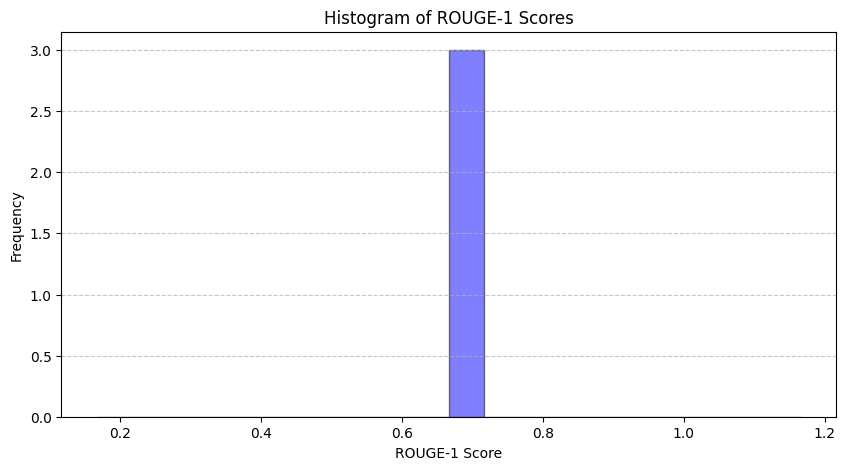

In [ ]:
# Create histograms for ROUGE-1
rouge1_scores = [score for score in average_rouge_scores["rouge1"].values()]
create_histogram(rouge1_scores, "1")

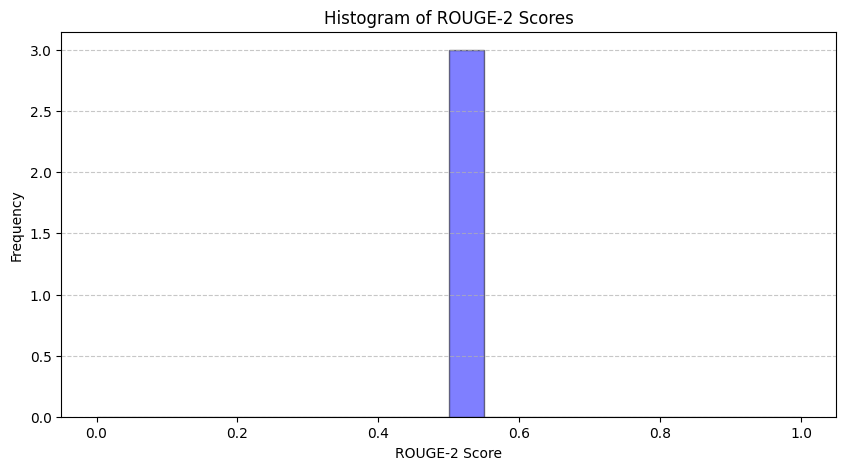

In [ ]:
# Create histograms for ROUGE-2
rouge2_scores = [score for score in average_rouge_scores["rouge2"].values()]
create_histogram(rouge2_scores, "2")

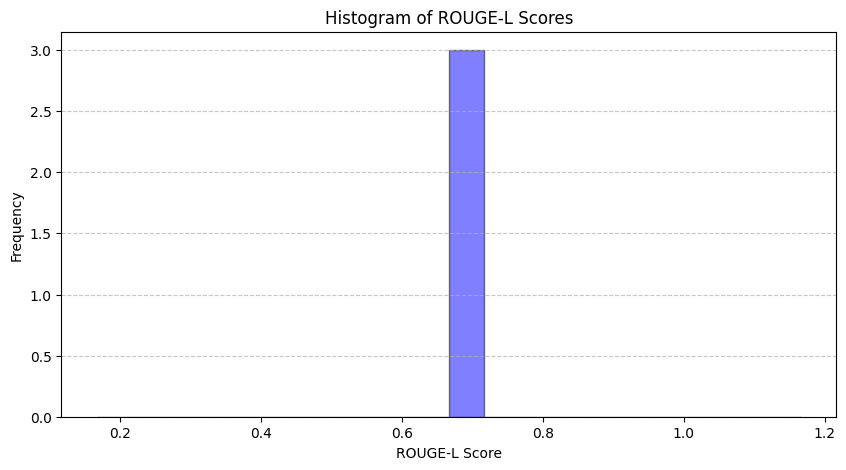

In [ ]:
# Create histograms for ROUGE-L
rougeL_scores = [score for score in average_rouge_scores["rougeL"].values()]
create_histogram(rougeL_scores, "L")

In [ ]:
# Combine the ROUGE scores for ROUGE-1, ROUGE-2, and ROUGE-L
rouge1_scores = [score for score in average_rouge_scores["rouge1"].values()]
rouge2_scores = [score for score in average_rouge_scores["rouge2"].values()]
rougeL_scores = [score for score in average_rouge_scores["rougeL"].values()]

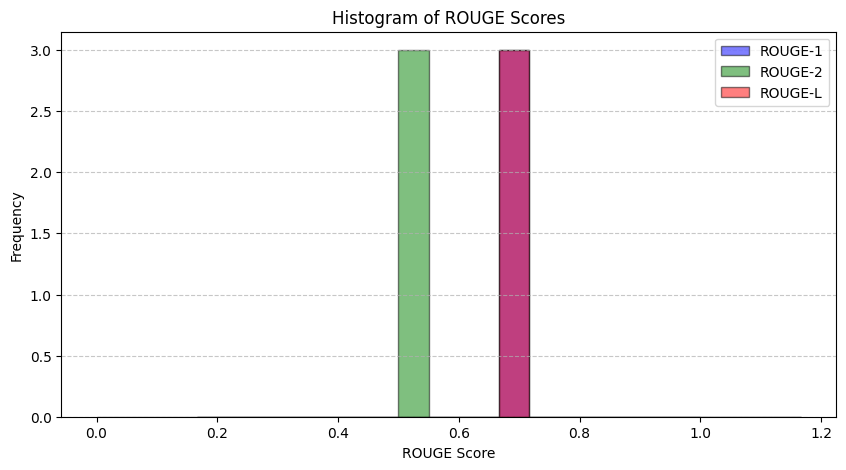

In [ ]:
# Create a histogram with different colors for each metric
plt.figure(figsize=(10, 5))
plt.hist(rouge1_scores, bins=20, alpha=0.5, color='blue', label='ROUGE-1', edgecolor='black')
plt.hist(rouge2_scores, bins=20, alpha=0.5, color='green', label='ROUGE-2', edgecolor='black')
plt.hist(rougeL_scores, bins=20, alpha=0.5, color='red', label='ROUGE-L', edgecolor='black')

plt.title("Histogram of ROUGE Scores")
plt.xlabel("ROUGE Score")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
!pip install datasets
!pip install bert-score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

ms2_dataset = load_dataset("allenai/ms2_sparse_max", split="test")


In [ ]:
from bert_score import score


In [ ]:
from datasets import load_dataset

dataset = load_dataset("allenai/ms2_sparse_max", split="test")


In [ ]:
for example in dataset:
    print(example)
    break

{'review_id': '24894943', 'pmid': ['19632716', '20573926', '23724913', '21903745'], 'title': ['Radiotherapy plus chemotherapy with or without surgical resection for stage III non-small-cell lung cancer: a phase III randomised controlled trial', 'Gefitinib or chemotherapy for non-small-cell lung cancer with mutated EGFR.', 'Crizotinib versus chemotherapy in advanced ALK-positive lung cancer.', 'Sequential vs. concurrent chemoradiation for stage III non-small cell lung cancer: randomized phase III trial RTOG 9410.'], 'abstract': ['BACKGROUND Results from phase II studies in patients with stage IIIA non-small-cell lung cancer with ipsilateral mediastinal nodal metastases ( N2 ) have shown the feasibility of resection after concurrent chemotherapy and radiotherapy with promising rates of survival . We therefore did this phase III trial to compare concurrent chemotherapy and radiotherapy followed by resection with st and ard concurrent chemotherapy and definitive radiotherapy without resect

In [ ]:
reference_sentences = []  # Populate this list with reference sentences

# You can loop through your dataset and extract reference sentences from it
for example in ms2_dataset:
    reference_sentences.append(example['review_id'])


In [ ]:
hypotheses = [example['review_id'] for example in ms2_dataset]

P, R, F1 = score(hypotheses, reference_sentences, lang='en', verbose=True)

# P, R, and F1 will contain precision, recall, and F1 score values respectively for each example in your dataset.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/27 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/27 [00:00<?, ?it/s]

done in 96.88 seconds, 17.21 sentences/sec


In [ ]:
for i, example in enumerate(ms2_dataset):
    print(f"Example {i + 1} - Precision: {P[i]:.4f}, Recall: {R[i]:.4f}, F1 Score: {F1[i]:.4f}")

Example 1 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 2 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 3 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 4 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 5 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 6 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 7 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 8 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 9 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 10 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 11 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 12 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 13 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 14 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 15 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Example 16 - Precision: 1.0000, Re

In [ ]:
pip install transformers


In [ ]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def preprocess_function(examples):
    inputs = tokenizer(examples['input_text'], return_tensors='pt', padding=True, truncation=True)
    targets = tokenizer(examples['target_text'], return_tensors='pt', padding=True, truncation=True)
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': targets['input_ids'],
    }

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    evaluation_strategy="steps",
    output_dir="./t5-fine-tuned-model",
    save_total_limit=5,
    save_steps=500,
    eval_steps=500,
    num_train_epochs=3,
    report_to="tensorboard",
)

In [ ]:
from datasets import load_dataset

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=preprocess_function,
)

NameError: ignored